# Importowanie bibliotek

### Dodanie ścieżki do projektu

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imporotowanie

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from corona_analysis.utils import save, paths
from pathlib import Path
from corona_analysis.scrapers import healthdata, koronawirusunas, meteostat, policjapl, rmf24, wiki_demo, wiki_urban

# Wczytanie danych

In [4]:
df = pd.read_csv(Path(paths.get_path(), "df.csv"), index_col=0, parse_dates=True, dayfirst=True)

Sprawdzam czy w danych nie ma braków, a jeżeli są to uzupełniam je 0.

In [5]:
df.head(3)

,Unnamed: 0.1,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor,date
2020-01-01,12.0,19145.0,734.0,188.0,332.0,42.0,1.0,46.0,1.4,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-02,11.0,14654.0,513.0,333.0,166.0,60.0,5.0,67.0,0.8,-1.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2020-01-03,10.0,15507.0,468.0,405.0,122.0,62.0,3.0,69.0,0.5,-4.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [6]:
df.tail(3)

,Unnamed: 0.1,Interwencje,Zatrzymani na gorącym uczynku,Zatrzymani poszukiwani,Zatrzymani nietrzeźwi kierujący,Wypadki drogowe,Zabici w wypadkach,Ranni w wypadkach,temperature,temperature_min,...,chor,zgo,wyl,pieszo,pojazdem,hosp,kwar,kwar_z,nadzor,date
2020-05-26,1.0,15783.0,562.0,281.0,144.0,48.0,3.0,54.0,13.9,8.0,...,11030.0,1024.0,10020.0,-31.65,-5.06,2171.0,78864.0,0.0,19139.0,146.0
2020-05-27,0.0,16226.0,596.0,311.0,186.0,60.0,6.0,65.0,14.8,8.0,...,11115.0,1028.0,10330.0,-31.65,-5.06,2320.0,79007.0,0.0,19682.0,147.0
2020-05-28,0.0,16226.0,596.0,311.0,186.0,60.0,6.0,65.0,15.9,8.0,...,11227.0,1038.0,10560.0,-31.65,-5.06,2248.0,79818.0,0.0,19373.0,148.0


In [7]:
woj = koronawirusunas.SUB_SITES
wojewodztwa = pd.DataFrame()
for i in range(1, len(woj)):
    dat = pd.read_csv(Path(paths.get_path(), woj[i][12:] + ".csv"), index_col=0, parse_dates=True, dayfirst=True)
    dat.fillna(axis=1, inplace=True, value=0)
    dat["wojewodztwo"] = np.nan
    dat.fillna(axis=1, inplace=True, value=woj[i][12:])
    dat["date"] = (dat.index - dat.index.min())  / np.timedelta64(1,'D')
    wojewodztwa = wojewodztwa.append(dat)

In [8]:
woj_info = pd.read_csv(Path(paths.get_path(), "woj_info.csv"), index_col=0, parse_dates=True, dayfirst=True)

# Przygotowanie danych do analizy

In [9]:
df = df[df.index >= "2020-03-01"]
df['zar_log'] = np.log(df["confirmed_infections"] + 1)

In [10]:
df['daily_inf'] = df['zar'].diff(1)
df['sum'] = df["confirmed_infections"].cumsum()

## Przygowowanie danych dla Śląska

In [11]:
df['suma'] =  df['zar']
df.loc[min(wojewodztwa.index):max(wojewodztwa.index),'suma'] = df.loc[min(wojewodztwa.index):max(wojewodztwa.index)]['suma'] - wojewodztwa[wojewodztwa.wojewodztwo == "slaskie"].zar
df['diff'] = df['suma'].diff(1)

# Analiza

In [12]:
df.columns

Index(['Unnamed: 0.1', 'Interwencje', 'Zatrzymani na gorącym uczynku',
       'Zatrzymani poszukiwani', 'Zatrzymani nietrzeźwi kierujący',
       'Wypadki drogowe', 'Zabici w wypadkach', 'Ranni w wypadkach',
       'temperature', 'temperature_min', 'temperature_max', 'winddirection',
       'windspeed', 'pressure', 'allbed_mean', 'ICUbed_mean', 'deaths_mean',
       'admis_mean', 'newICU_mean', 'totdea_mean', 'bedover_mean',
       'icuover_mean', 'mobility_composite', 'total_tests',
       'confirmed_infections', 'smp', 'testy', 'testyl', 'zar', 'chor', 'zgo',
       'wyl', 'pieszo', 'pojazdem', 'hosp', 'kwar', 'kwar_z', 'nadzor', 'date',
       'zar_log', 'daily_inf', 'sum', 'suma', 'diff'],
      dtype='object')

## Wykresy dla całego kraju

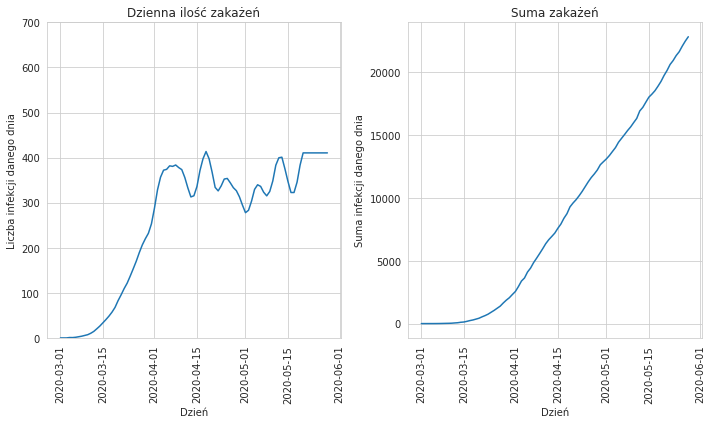

In [13]:
from matplotlib import pyplot as plt

sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

ax1 = plt.subplot(121)

sns.lineplot(x='index', y='confirmed_infections', data=df.reset_index(), legend=False, ax=ax1)
ax1.set(ylabel='Liczba infekcji danego dnia', xlabel='Dzień')
ax1.set_title("Dzienna ilość zakażeń")
ax1.set_ylim([0,700])
plt.xticks(rotation = 'vertical')

ax2 = plt.subplot(122)
sns.lineplot(x='index', y='zar', data=df.reset_index(), legend=False, ax=ax2)
ax2.set(ylabel='Suma infekcji danego dnia', xlabel='Dzień')
ax2.set_title("Suma zakażeń")
plt.xticks(rotation = 'vertical')


plt.tight_layout()

plt.savefig("../img/dane_marzec.png", dpi=200)

Dane przedstawione na poniższych wykresach obejmują okres: 01.03.2020 - 19.05.2020

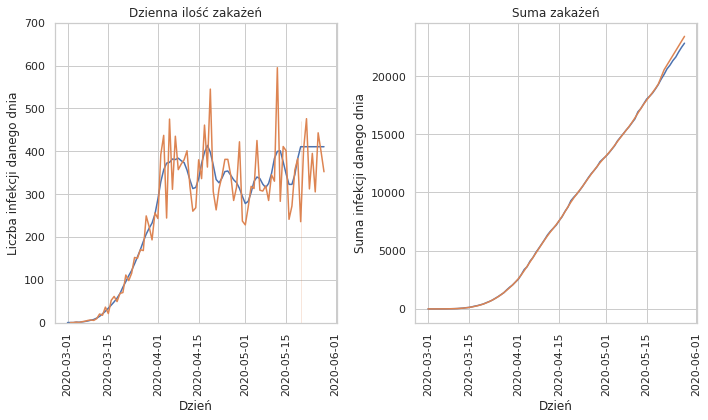

In [37]:
sns.set_style("whitegrid")

plt.figure(figsize=(10,6))


# First plot
ax1 = plt.subplot(121)

sns.lineplot(x='index', y='confirmed_infections', data=df.reset_index(), ax=ax1)
ax1.set(ylabel='Liczba infekcji danego dnia', xlabel='Dzień')
ax1.set_title("Dzienna ilość zakażeń")

sns.lineplot(x='index', y='daily_inf', data=df.reset_index(), ax=ax1)
ax1.set(ylabel='Liczba infekcji danego dnia', xlabel='Dzień')
ax1.set_title("Dzienna ilość zakażeń")
ax1.set_ylim([0,700])
plt.xticks(rotation = 'vertical')


# Second plot
ax2 = plt.subplot(122)
sns.lineplot(x='index', y='zar', data=df.reset_index(), legend=False, ax=ax2)
ax2.set(ylabel='Suma infekcji danego dnia', xlabel='Dzień')
ax2.set_title("Suma zakażeń")
plt.xticks(rotation = 'vertical')

ax2 = plt.subplot(122)
sns.lineplot(x='index', y='sum', data=df.reset_index(), legend=False, ax=ax2)
ax2.set(ylabel='Suma infekcji danego dnia', xlabel='Dzień')


plt.tight_layout()

plt.savefig("../img/dane_marzec_porownanie.png", dpi=200)

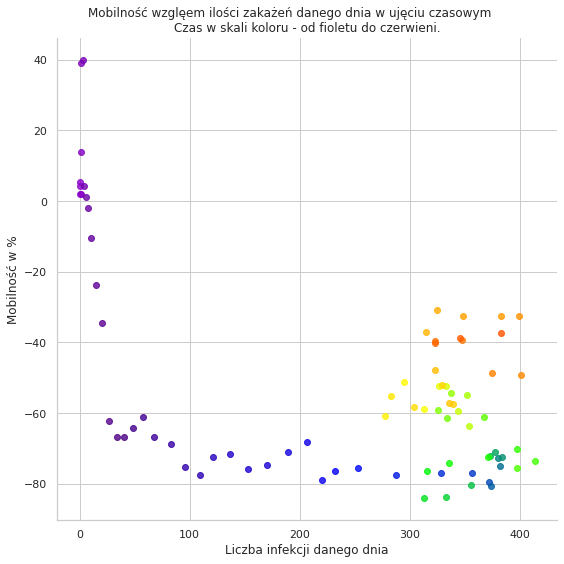

In [48]:
ax = sns.lmplot(x='confirmed_infections', y='pieszo', hue='date', data=df[df.index < "2020-05-20"], palette=sns.blend_palette(colors=("#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"),n_colors=len(df['date'])), legend=False, height = 8)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.title("Mobilność wzglęem ilości zakażeń danego dnia w ujęciu czasowym \
        \nCzas w skali koloru - od fioletu do czerwieni.")
plt.tight_layout()
plt.savefig("../img/fazy_w_czasie.png", dpi=200)

Na wykresie znajdują się dane od momentu wystąpienia pierwszych przypadków koronawirusa w polsce. W miarę upływu czasu pomimo spadku
mobilności ludności, ilość zachorowań ustabilizowała się na poziomie ~350/dzień. Na wykresie widać pewne fazy (gwałtowne przeskoki
między kolejnymi poziomami mobilności). Na następnym wykresie dane zotały podzielone na grupy względem odchylenia standardowego.

/home/pk/miniconda3/envs/corona-analysis-1/lib/python3.8/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


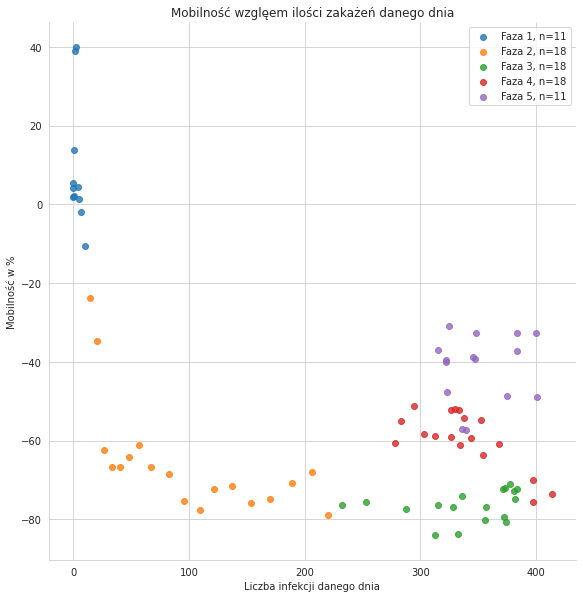

In [16]:
df.loc[0:11,'label'] = 0
df.loc[11:,'label'] = 1
df.loc[29:,'label'] = 2
df.loc[47:,'label'] = 3
df.loc[65:,'label'] = 4
ax = sns.lmplot(x="confirmed_infections", y="pieszo", data=df[df.index < "2020-05-20"], fit_reg= False, height = 8, hue = "label", legend = False)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.legend(labels=['Faza 1, n=11', 'Faza 2, n=18', 'Faza 3, n=18', 'Faza 4, n=18', 'Faza 5, n=11'])
plt.title("Mobilność wzglęem ilości zakażeń danego dnia")
plt.show()

Dane podzielone zostały na 5 Faz. Charakteryzują się one pewnymi podobnymi cechami, które wydoczne są także poniżej w danych statystycznych. Każda z grup składa się z około 11-18 punktów (dni). 3 Ostatnie fazy są szczególnie podobne do siebie, ich sd w mobilności jest niemalże identyczne i wynosi ~5, podobnie jest w kolmnie infekcje ~31.

In [17]:
df.groupby('label').agg(np.std)['confirmed_infections']

label
0.0     3.424840
1.0    67.014140
2.0    45.369417
3.0    38.238815
4.0    37.303563
Name: confirmed_infections, dtype: float64

In [18]:
df.groupby('label').agg(np.std)['pieszo']

label
0.0    16.133486
1.0    14.297152
2.0     3.877869
3.0     7.243015
4.0     8.911826
Name: pieszo, dtype: float64

In [19]:
df.groupby('label').agg(len)['pieszo']

label
0.0    11
1.0    18
2.0    18
3.0    18
4.0    25
Name: pieszo, dtype: int64

In [20]:
df.groupby('label').agg(np.mean)['pieszo']

label
0.0     9.066364
1.0   -65.560556
2.0   -76.538889
3.0   -59.616111
4.0   -37.704400
Name: pieszo, dtype: float64

In [21]:
df.groupby('label').agg(np.mean)['confirmed_infections']

label
0.0      2.949136
1.0     99.690085
2.0    340.336432
3.0    338.125863
4.0    374.900424
Name: confirmed_infections, dtype: float64

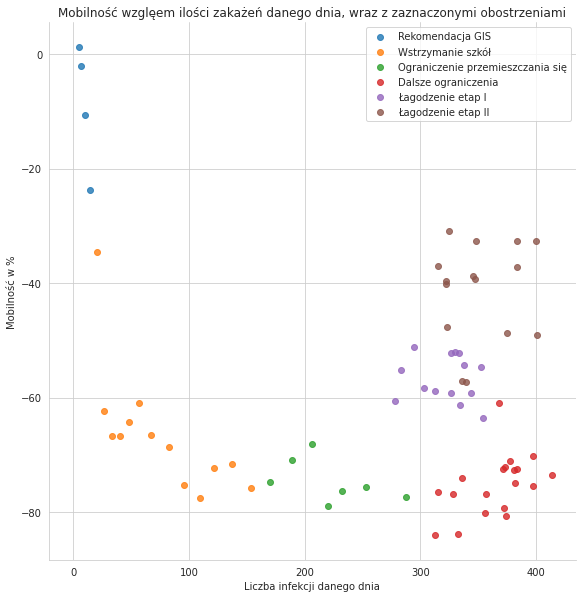

<Figure size 432x288 with 0 Axes>

In [22]:
df.loc[df.index > "2020-03-8",'faza'] = 0
df.loc[df.index > "2020-03-12",'faza'] = 1
df.loc[df.index > "2020-03-25",'faza'] = 2
df.loc[df.index > "2020-04-01",'faza'] = 3
df.loc[df.index > "2020-04-20",'faza'] = 4
df.loc[df.index > "2020-05-04",'faza'] = 5
ax = sns.lmplot(x="confirmed_infections", y="pieszo", data=df[df.index < "2020-05-20"], fit_reg= False, height = 8, hue = "faza", legend = False)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.legend(labels=['Rekomendacja GIS', 'Wstrzymanie szkół', 'Ograniczenie przemieszczania się','Dalsze ograniczenia','Łagodzenie etap I', 'Łagodzenie etap II'])
plt.title("Mobilność wzglęem ilości zakażeń danego dnia, wraz z zaznaczonymi obostrzeniami")
plt.show()
plt.savefig("fazy_porownanie_cale.png")

## Wykresy nie wliczając Śląska

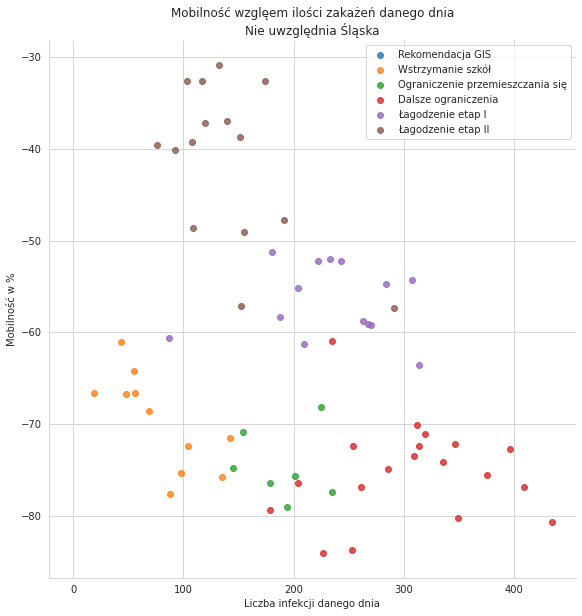

In [23]:
ax = sns.lmplot(x="diff", y="pieszo", data=df[df.index < "2020-05-20"], fit_reg= False, height = 8, hue = "faza", legend = False)
ax.set(ylabel='Mobilność w %', xlabel='Liczba infekcji danego dnia')
plt.legend(labels=['Rekomendacja GIS', 'Wstrzymanie szkół', 'Ograniczenie przemieszczania się','Dalsze ograniczenia','Łagodzenie etap I', 'Łagodzenie etap II'], loc=1)
plt.title("Mobilność wzglęem ilości zakażeń danego dnia\nNie uwzględnia Śląska")
plt.show()

## Ilość policyjnych interwencji podczas pandemii

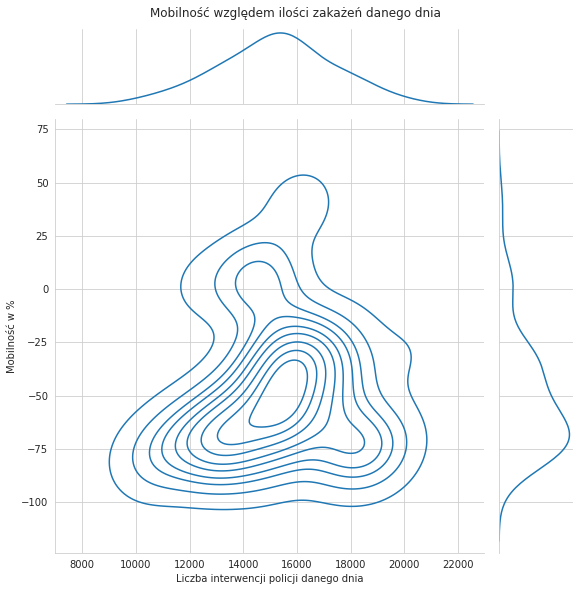

In [24]:
ax = sns.jointplot(y="pieszo", x="Interwencje", data=df, height = 8, kind="kde")
ax.set_axis_labels(ylabel='Mobilność w %', xlabel='Liczba interwencji policji danego dnia')
plt.suptitle("Mobilność względem ilości zakażeń danego dnia", y = 1.02)
plt.show()

## Ilość wypadków drogowych podczas pandemii

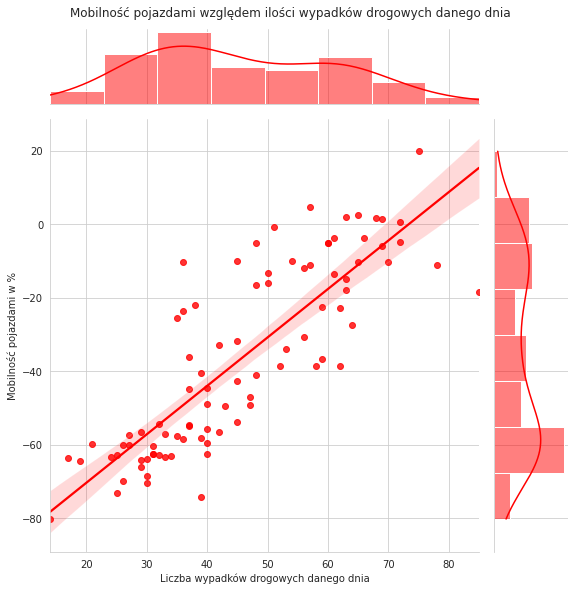

In [25]:
ax = sns.jointplot(y="pojazdem", x="Wypadki drogowe", data=df, height = 8, kind = "reg", color = "r")
ax.set_axis_labels(ylabel='Mobilność pojazdami w %', xlabel='Liczba wypadków drogowych danego dnia')
plt.suptitle("Mobilność pojazdami względem ilości wypadków drogowych danego dnia", y = 1.02)
plt.show()

## Ilość zarażonych w województwach względem danych demograficznych i urbanizacji

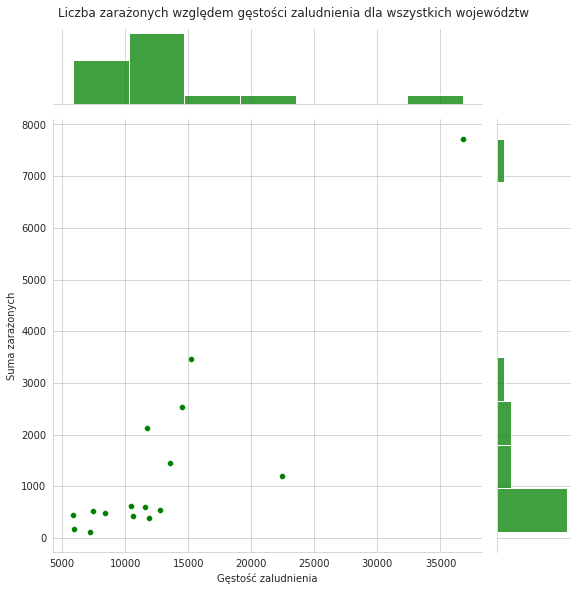

In [26]:
ax = sns.jointplot(x="gestosc_zal", y="zar", data=woj_info, height = 8, color="g")
ax.set_axis_labels(ylabel='Suma zarażonych', xlabel='Gęstość zaludnienia')
plt.suptitle("Liczba zarażonych względem gęstości zaludnienia dla wszystkich województw", y = 1.02)
plt.show()

In [27]:
woj_info.columns

Index(['wojewodztwo', 'powierzchnina', 'ludnosc', 'gestosc_zal', 'urbanizacja',
       'stopa_bezrobocia', 'pdb_na_miesz', 'miasta', 'powiaty', 'm_powiaty',
       'gminy_ogolem', 'miejskie', 'wiejskie', 'miejsko_wiejskie', 'zar',
       'chor', 'zgo', 'wyl', 'date'],
      dtype='object')

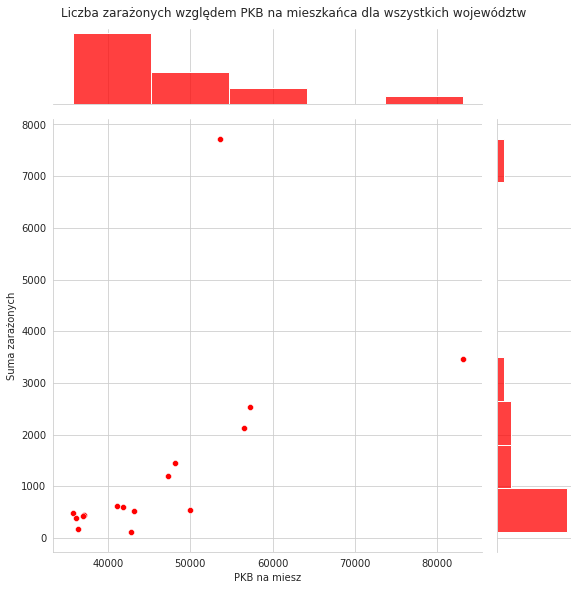

In [28]:
ax = sns.jointplot(x="pdb_na_miesz", y="zar", data=woj_info, height = 8, color="r")
ax.set_axis_labels(ylabel='Suma zarażonych', xlabel='PKB na miesz')
plt.suptitle("Liczba zarażonych względem PKB na mieszkańca dla wszystkich województw", y = 1.02)
plt.show()

In [29]:
woj_info['zar']

0     2530
1      595
2      484
3      113
4     1458
5     1190
6     3461
7      624
8      380
9      442
10     548
11    7728
12     432
13     179
14    2133
15     527
Name: zar, dtype: int64

# Pozostałe wykresy

## Zakażenia w województwach

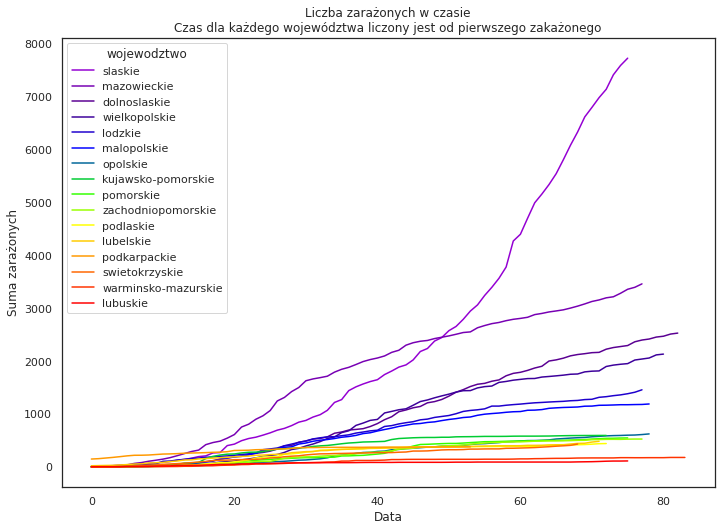

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
ax = sns.lineplot(x = "date", y = "zar", data = wojewodztwa, hue = "wojewodztwo", legend='brief', palette=sns.blend_palette(colors=("#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"),n_colors=16))
ax.set(ylabel='Suma zarażonych', xlabel='Data')
plt.title("Liczba zarażonych w czasie\nCzas dla każdego województwa liczony jest od pierwszego zakażonego")
plt.show()

## Wykresy sumy zakażeń w Polsce

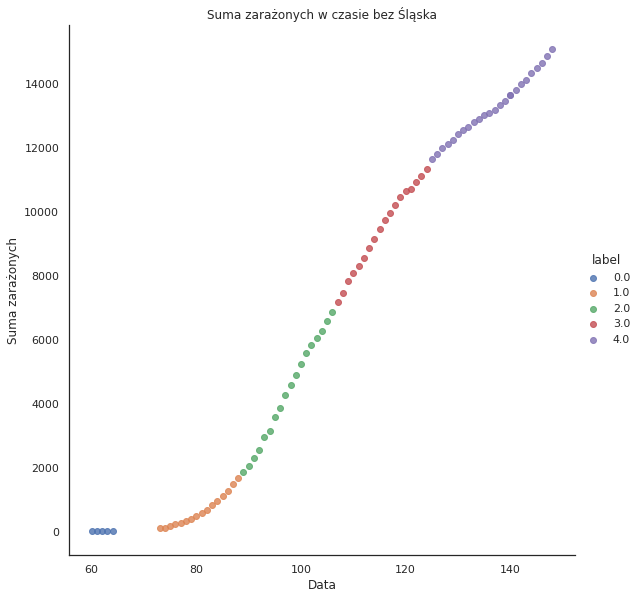

In [31]:
ax = sns.lmplot(y="suma", x="date", data=df, fit_reg= False, height = 8, hue = "label")
ax.set(ylabel='Suma zarażonych', xlabel='Data')
plt.title("Suma zarażonych w czasie bez Śląska")
plt.show()

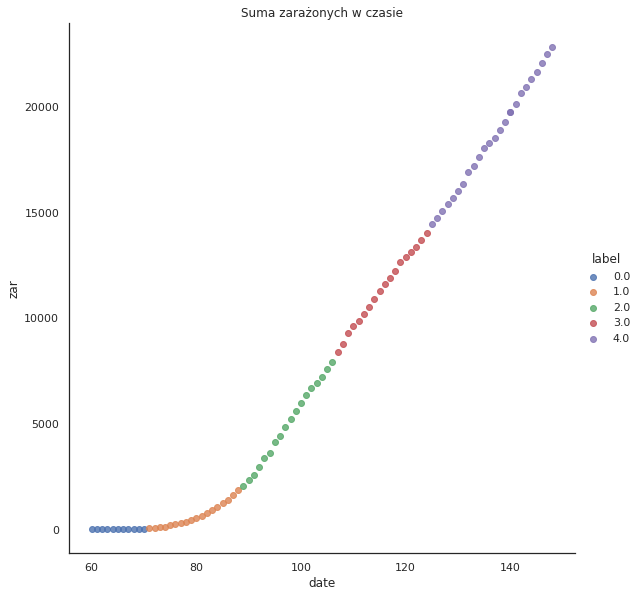

In [32]:
sns.lmplot(y="zar", x="date", data=df, fit_reg= False, height = 8, hue = "label")
ax.set(ylabel='Suma zarażonych', xlabel='Data')
plt.title("Suma zarażonych w czasie")
plt.show()

In [33]:
df.columns

Index(['Unnamed: 0.1', 'Interwencje', 'Zatrzymani na gorącym uczynku',
       'Zatrzymani poszukiwani', 'Zatrzymani nietrzeźwi kierujący',
       'Wypadki drogowe', 'Zabici w wypadkach', 'Ranni w wypadkach',
       'temperature', 'temperature_min', 'temperature_max', 'winddirection',
       'windspeed', 'pressure', 'allbed_mean', 'ICUbed_mean', 'deaths_mean',
       'admis_mean', 'newICU_mean', 'totdea_mean', 'bedover_mean',
       'icuover_mean', 'mobility_composite', 'total_tests',
       'confirmed_infections', 'smp', 'testy', 'testyl', 'zar', 'chor', 'zgo',
       'wyl', 'pieszo', 'pojazdem', 'hosp', 'kwar', 'kwar_z', 'nadzor', 'date',
       'zar_log', 'daily_inf', 'sum', 'suma', 'diff', 'label', 'faza'],
      dtype='object')

# Ploty do prezentacji

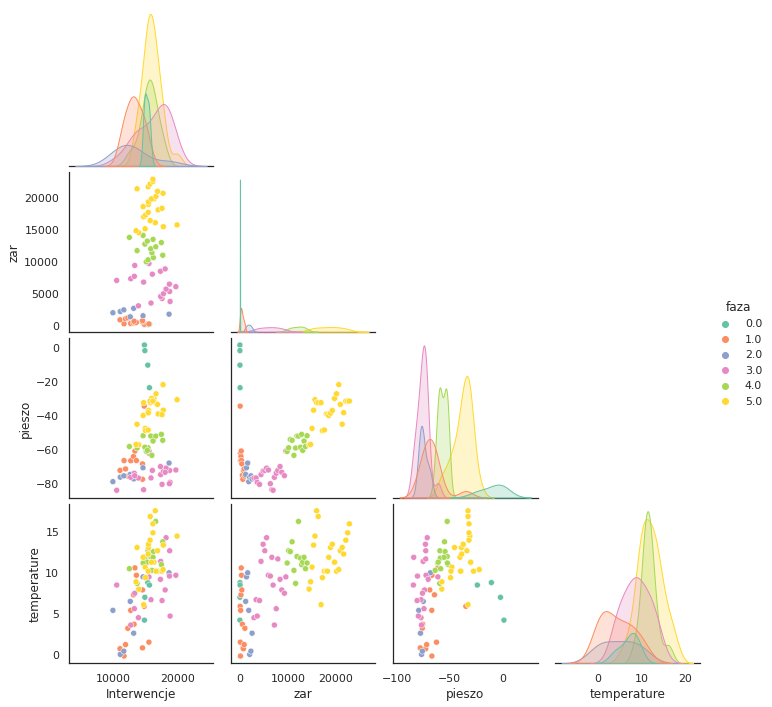

In [34]:
sns.pairplot(df.loc[:, ["faza", "Interwencje", "zar", "pieszo", "temperature"]], kind="scatter", hue="faza", palette="Set2", corner = True)

<AxesSubplot:>

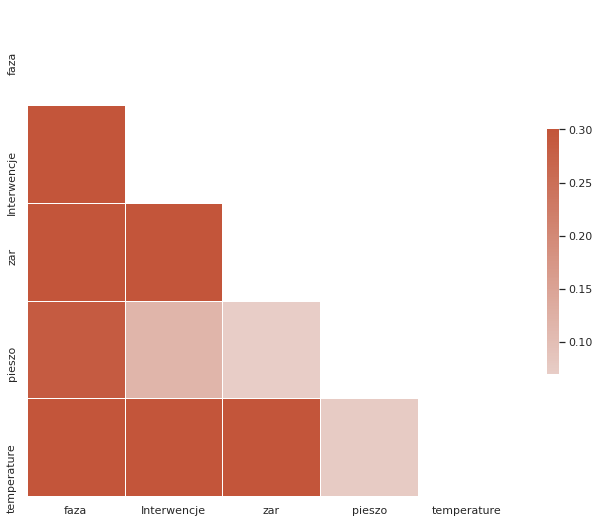

In [35]:
corr = df.loc[:, ["faza", "Interwencje", "zar", "pieszo", "temperature"]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [36]:
corr

,faza,Interwencje,zar,pieszo,temperature
faza,1.000000,0.382792,0.937589,0.285810,0.663308
Interwencje,0.382792,1.000000,0.340217,0.115962,0.564091
zar,0.937589,0.340217,1.000000,0.070060,0.689362
pieszo,0.285810,0.115962,0.070060,1.000000,0.073554
temperature,0.663308,0.564091,0.689362,0.073554,1.000000


# ARIMA

In [36]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

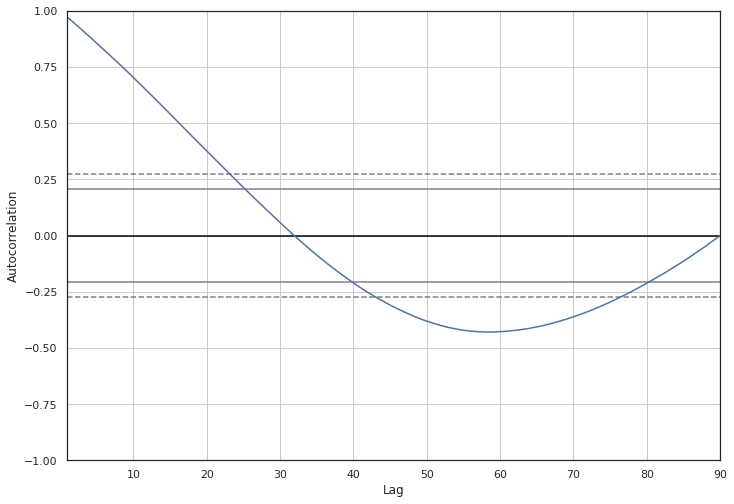

In [37]:
autocorrelation_plot(df.loc[:, "zar"])

In [38]:
df.columns

Index(['Unnamed: 0.1', 'Interwencje', 'Zatrzymani na gorącym uczynku',
       'Zatrzymani poszukiwani', 'Zatrzymani nietrzeźwi kierujący',
       'Wypadki drogowe', 'Zabici w wypadkach', 'Ranni w wypadkach',
       'temperature', 'temperature_min', 'temperature_max', 'winddirection',
       'windspeed', 'pressure', 'allbed_mean', 'ICUbed_mean', 'deaths_mean',
       'admis_mean', 'newICU_mean', 'totdea_mean', 'bedover_mean',
       'icuover_mean', 'mobility_composite', 'total_tests',
       'confirmed_infections', 'smp', 'testy', 'testyl', 'zar', 'chor', 'zgo',
       'wyl', 'pieszo', 'pojazdem', 'hosp', 'kwar', 'kwar_z', 'nadzor', 'date',
       'zar_log', 'daily_inf', 'sum', 'suma', 'diff', 'label', 'faza'],
      dtype='object')

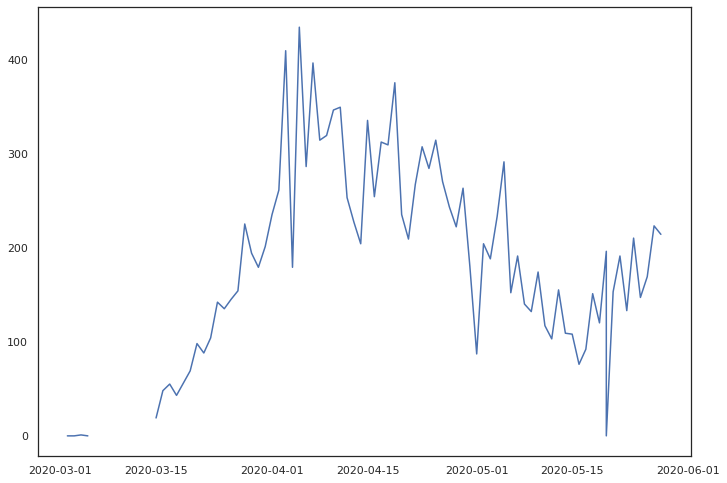

In [39]:
plt.plot(df['diff'])

In [40]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from matplotlib import pyplot
df.index = pd.to_datetime(df.index)
series = pd.Series(df.loc[:, "diff"])

                               SARIMAX Results                                
Dep. Variable:                   diff   No. Observations:                   90
Model:                ARIMA(10, 1, 0)   Log Likelihood                -437.637
Date:                Sat, 28 Aug 2021   AIC                            897.274
Time:                        08:41:28   BIC                            924.649
Sample:                    03-01-2020   HQIC                           908.308
                         - 05-28-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6882      0.095     -7.215      0.000      -0.875      -0.501
ar.L2         -0.2569      0.135     -1.908      0.056      -0.521       0.007
ar.L3         -0.1685      0.147     -1.143      0.2

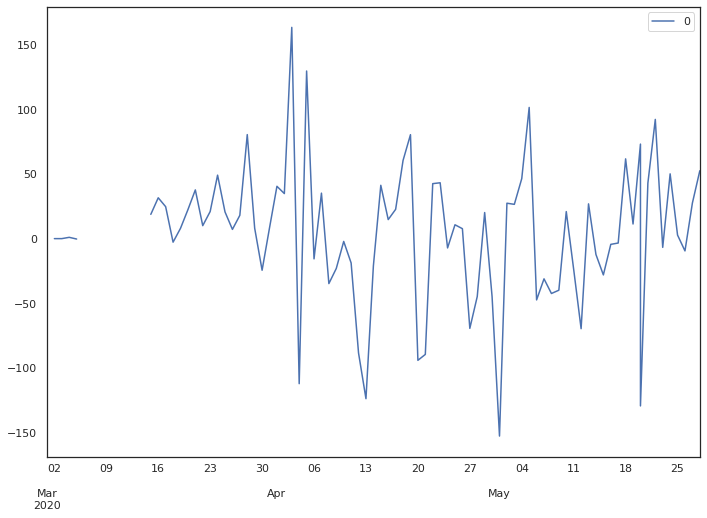

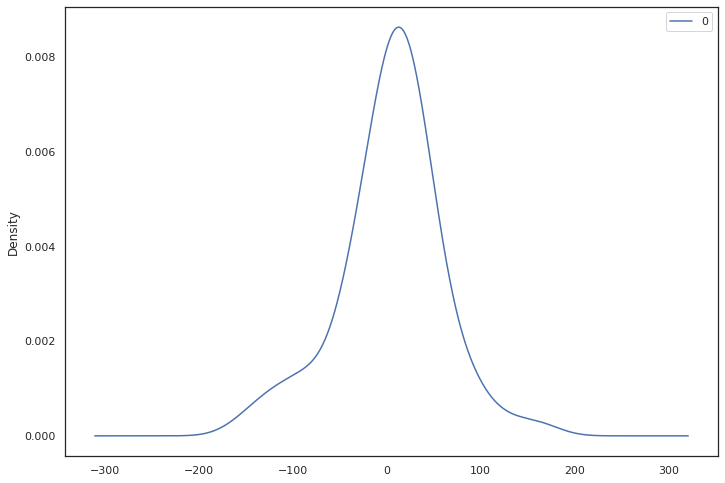

                0
count   80.000000
mean     4.491760
std     54.640362
min   -152.688592
25%    -21.634403
50%      8.186427
75%     34.930256
max    163.368200


In [41]:
series.index = series.index.to_period('D')
# fit model
model = ARIMA(series, order=(10,1,0)).fit()
# summary of fit model
print(model.summary())
# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [46]:
import pmdarima
stepwise_model = pmdarima.auto_arima(series[20:], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=695.512, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=667.320, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=664.409, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=677.915, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=668.128, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.10 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=684.056, Time=0.14 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=664.414, Time=0.31 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=665.379, Time=0.52 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit

In [58]:
p = model.predict(5)

In [57]:
model.predict(5)

2020-03-06      0.470723
2020-03-07      0.210314
2020-03-08      0.338381
2020-03-09      0.427215
2020-03-10      0.303384
                 ...    
2020-05-24    159.909104
2020-05-25    144.275582
2020-05-26    178.497444
2020-05-27    195.487651
2020-05-28    161.522317
Freq: D, Name: predicted_mean, Length: 85, dtype: float64

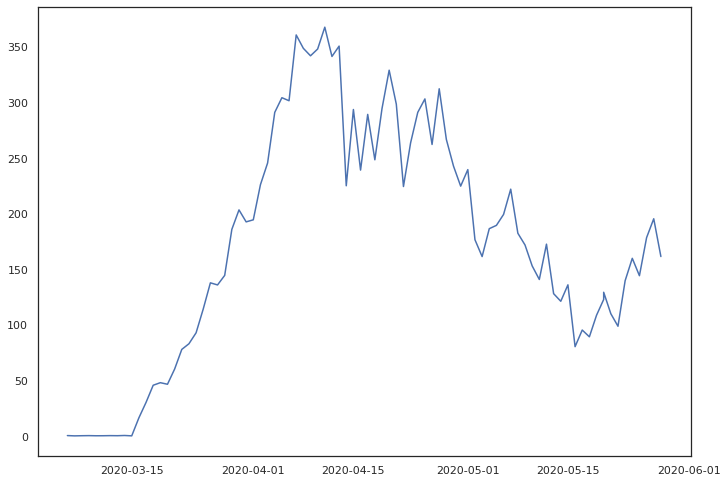

In [59]:
plt.plot(p.index.to_timestamp(), p.to_numpy())

In [76]:
model = stepwise_model.fit(series[20:])

Help on method predict in module pmdarima.arima.arima:

predict(n_periods=10, X=None, return_conf_int=False, alpha=0.05, **kwargs) method of pmdarima.arima.arima.ARIMA instance
    Forecast future values
    
    Generate predictions (forecasts) ``n_periods`` in the future.
    Note that if ``exogenous`` variables were used in the model fit, they
    will be expected for the predict procedure and will fail otherwise.
    
    Parameters
    ----------
    n_periods : int, optional (default=10)
        The number of periods in the future to forecast.
    
    X : array-like, shape=[n_obs, n_vars], optional (default=None)
        An optional 2-d array of exogenous variables. If provided, these
        variables are used as additional features in the regression
        operation. This should not include a constant or trend. Note that
        if an ``ARIMA`` is fit on exogenous features, it must be provided
        exogenous features for making predictions.
    
    return_conf_int : bool,

In [82]:
fors = model.predict(10, return_conf_int=True)
upper = intervals.to_numpy()[:,0]
lower = intervals.to_numpy()[:,1]

AttributeError: 'tuple' object has no attribute 'conf_int'

In [62]:
intervals.index.to_range(0)

AttributeError: 'PeriodIndex' object has no attribute 'to_range'

In [63]:
series

2020-03-01      NaN
2020-03-02      0.0
2020-03-03      0.0
2020-03-04      1.0
2020-03-05      0.0
              ...  
2020-05-24    210.0
2020-05-25    147.0
2020-05-26    169.0
2020-05-27    223.0
2020-05-28    214.0
Freq: D, Name: diff, Length: 90, dtype: float64

# Plot preditions

In [64]:
pred = model.forecast(100)

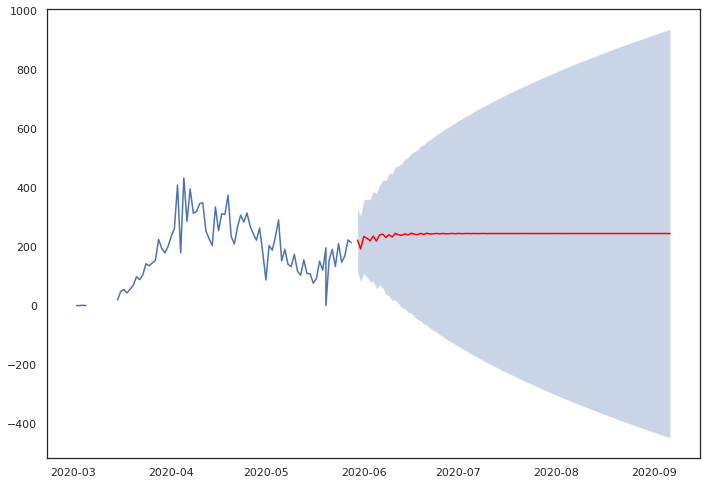

In [65]:
plt.plot(series.index.to_timestamp(),series.to_numpy())
plt.fill_between(x=intervals.index.to_timestamp(), y1=lower, y2=upper, alpha=0.3)
plt.plot(pred.index.to_timestamp(), pred.to_numpy(), c="red")

In [66]:
model.predict('2020-05-15', '2020-06-30')

2020-05-15    136.060336
2020-05-16     80.433250
2020-05-17     95.401859
2020-05-18     89.311348
2020-05-19    108.690169
2020-05-20    122.894354
2020-05-21    129.374798
2020-05-22    110.082896
2020-05-23     98.807272
2020-05-24    139.763676
2020-05-25    159.909104
2020-05-26    144.275582
2020-05-27    178.497444
2020-05-28    195.487651
2020-05-29    161.522317
2020-05-30    222.217689
2020-05-31    192.237201
2020-06-01    234.321790
2020-06-02    228.802009
2020-06-03    220.045941
2020-06-04    235.916852
2020-06-05    219.023095
2020-06-06    240.092575
2020-06-07    242.730729
2020-06-08    231.438732
2020-06-09    240.702073
2020-06-10    233.017920
2020-06-11    245.121316
2020-06-12    240.090311
2020-06-13    238.526126
2020-06-14    243.498678
2020-06-15    239.656004
2020-06-16    245.578357
2020-06-17    242.756189
2020-06-18    240.718710
2020-06-19    245.049319
2020-06-20    241.857990
2020-06-21    245.519254
2020-06-22    242.961270
2020-06-23    243.372414


In [45]:
object_methods = [method_name for method_name in dir(ARIMAResults)
                  if callable(getattr(ARIMAResults, method_name))]

In [44]:
statsmodels.__version__

'0.12.2'

/home/pk/miniconda3/envs/corona-analysis-1/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


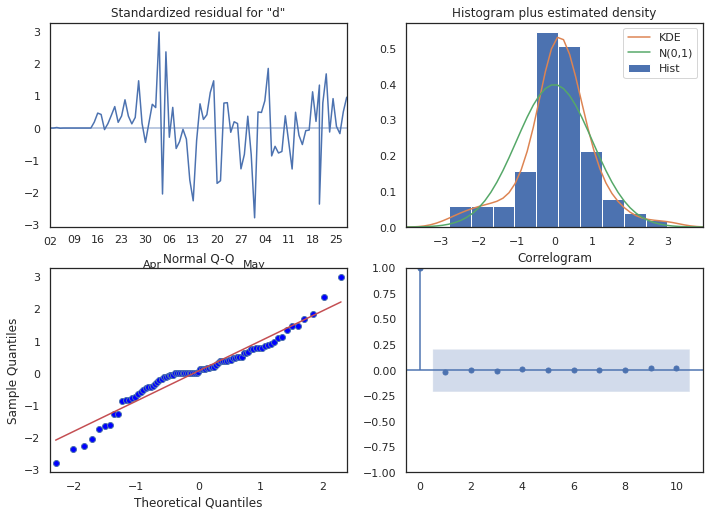

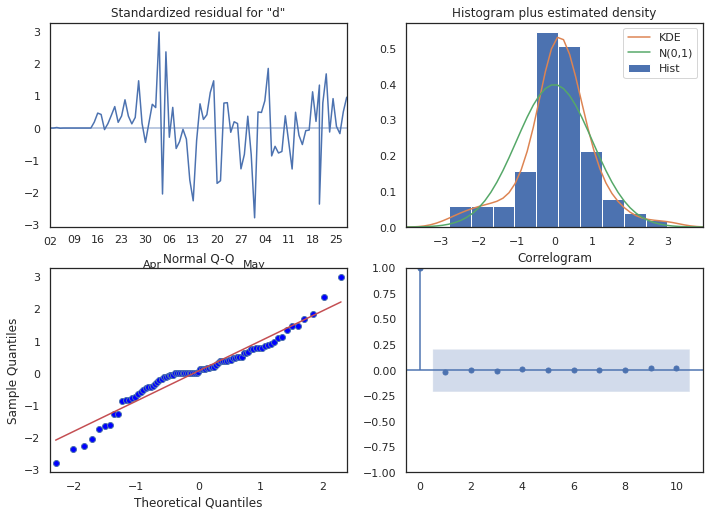

In [79]:
model.plot_diagnostics()